# SD-TSIA210 Machine Learning Project
## Binary classification
by Celine Beyrouthy, Bourhan Derknaya, Sahar Kiameh, Karim Reda.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving G_3_ant.npy to G_3_ant.npy
Saving G_3_grapes.npy to G_3_grapes.npy


In [ ]:
%%capture
#Generally Important libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Libraries for Gridsearch
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#Libraries for PCA
from sklearn.decomposition import PCA

#Libraries imported for the Decision Tree Part
from sklearn.tree import DecisionTreeClassifier, plot_tree

#Libraries imported for the Random forest part
from sklearn.ensemble import RandomForestClassifier

#Libraries for SVC
from sklearn.svm import SVC

#Libraries for MLP
from sklearn.neural_network import MLPClassifier

#Keras libraries for Neural Networks
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras import optimizers, initializers
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
def print_scores(train, test, classifier):
  print("The train score that we got using {} is: {}".format(classifier, train))
  print("The test score that we got using {} is: {}".format(classifier, test))

# Taking a first look at the data
We will start our study of the data in hand by taking an initial look on the data (dimensionality and all that).

In [ ]:
np.load('G_3_ant.npy').shape, np.load('G_3_grapes.npy').shape

((1000, 784), (1000, 784))

So from this we can see that we have 1000 images of ant and 1000 images of grapes and each image is represented by 784 features.

After reading the documentation, we grasp that the 784 features are a linearized 2-D image of 28x28 pixels, of a handwritten library of images.
Each pixel is saved in one byte = 256 bit.

We will start by making some preprocssing on the image by standarizing and normalizing.

In [ ]:
eps = 15

X_ant = np.load('G_3_ant.npy')
n_ant = X_ant.shape[0]
y_ant = np.ones(n_ant)
X_grapes = np.load('G_3_grapes.npy')
n_grapes = X_ant.shape[0]
y_grapes = np.zeros(n_grapes)
X_raw = np.vstack([X_ant, X_grapes])
y = np.hstack([y_ant, y_grapes])
X, y = shuffle(X_raw, y, random_state=None)
X[np.where(X<eps)] = 0  # ignore little points, small pixels
X = X / 255.
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)

In the above code we mixed the two data into one and shuffled them randomly in order to be able to classify them. We then split the data into training and testing.

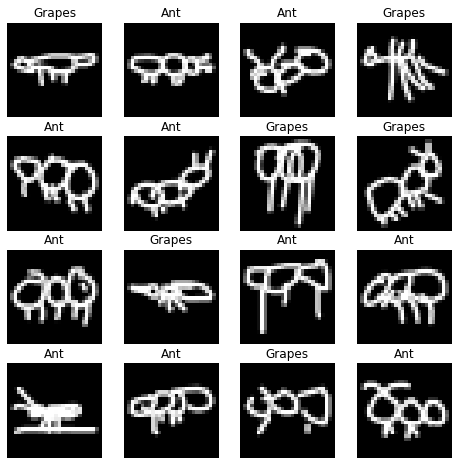

In [ ]:
fig = plt.figure(figsize=(8, 8))
rows = 4
columns = 4
for i in range(1,17):
  fig.add_subplot(rows, columns, i)
  plt.imshow(X_raw[i].reshape(28,28), cmap='gray')
  plt.axis('off')
  tmp = 'Ant' if y[i] == 1 else 'Grapes'
  plt.title(tmp)

We see here the original data, images are almost black and white, now we plot the normalized data:

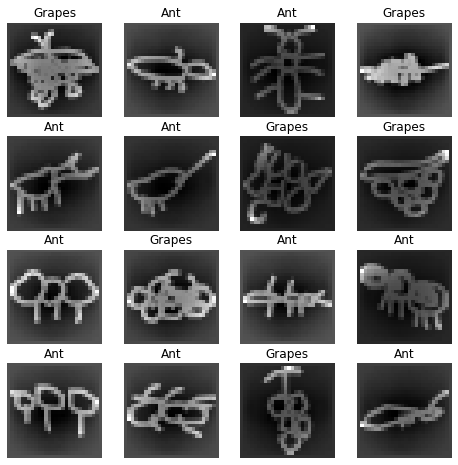

In [ ]:
fig = plt.figure(figsize=(8, 8))
rows = 4
columns = 4
for i in range(1,17):
  fig.add_subplot(rows, columns, i)
  plt.imshow(X[i].reshape(28,28), cmap='gray')
  plt.axis('off')
  tmp = 'Ant' if y[i] == 1 else 'Grapes'
  plt.title(tmp)

We notice how the data is normalized row-wise since the data is saved in a vector shaped-image.

We continue now to classify the data:

# Classifying the data
In order to classify the data, we are going to use multiple methods. The classifications methods that we are going to test can be seen in the following order


1.   Decision Tree
2.   Random Forest
3.   Support Vector Machine
4.   Neural Networks



## **Decision Trees**


#### **Without PCA:**
We will start by making a decision tree without PCA

In [ ]:
dtc = DecisionTreeClassifier(splitter='best').fit(X_train, y_train)
train_score = dtc.score(X_train, y_train) 
test_score = dtc.score(X_test, y_test)

In [ ]:
print_scores(train_score, test_score, "Decision Tree")

The train score that we got using Decision Tree is: 1.0
The test score that we got using Decision Tree is: 0.734


As we can see, since we didn't specify the max_depth parameter nor the minimum number of entries in a leaf, the model overfitted resulting in a poor performance. To improve the generalizzation of the tree, we are going to try to find the best max depth parameter and the minimum number of samples allowed in a leaf that will both insure a better accuracy.

In [ ]:
print("We note that the depth reached by the tree was",dtc.get_depth())

We note that the depth reached by the tree was 14


In [ ]:
grid = {'max_depth': np.arange(dtc.get_depth()), 'min_samples_leaf': np.arange(5)}
dtc_gscv = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = grid, n_jobs=-1)
dtc_gscv.fit(X_train,y_train)
print(dtc_gscv.best_score_)
print(dtc_gscv.best_params_)

0.774
{'max_depth': 4, 'min_samples_leaf': 2}


So, the best depth of a tree is 4. We are going to use that and print the best tree

In [ ]:
max_depth = dtc_gscv.best_params_['max_depth']
min_samples_leaf = dtc_gscv.best_params_['min_samples_leaf']

dtc_best_param = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf).fit(X_train, y_train)
train_score = dtc_best_param.score(X_train, y_train) 
test_score = dtc_best_param.score(X_test, y_test)
print_scores(train_score, test_score, "Decision Tree with best depth")

The train score that we got using Decision Tree with best depth is: 0.852
The test score that we got using Decision Tree with best depth is: 0.81


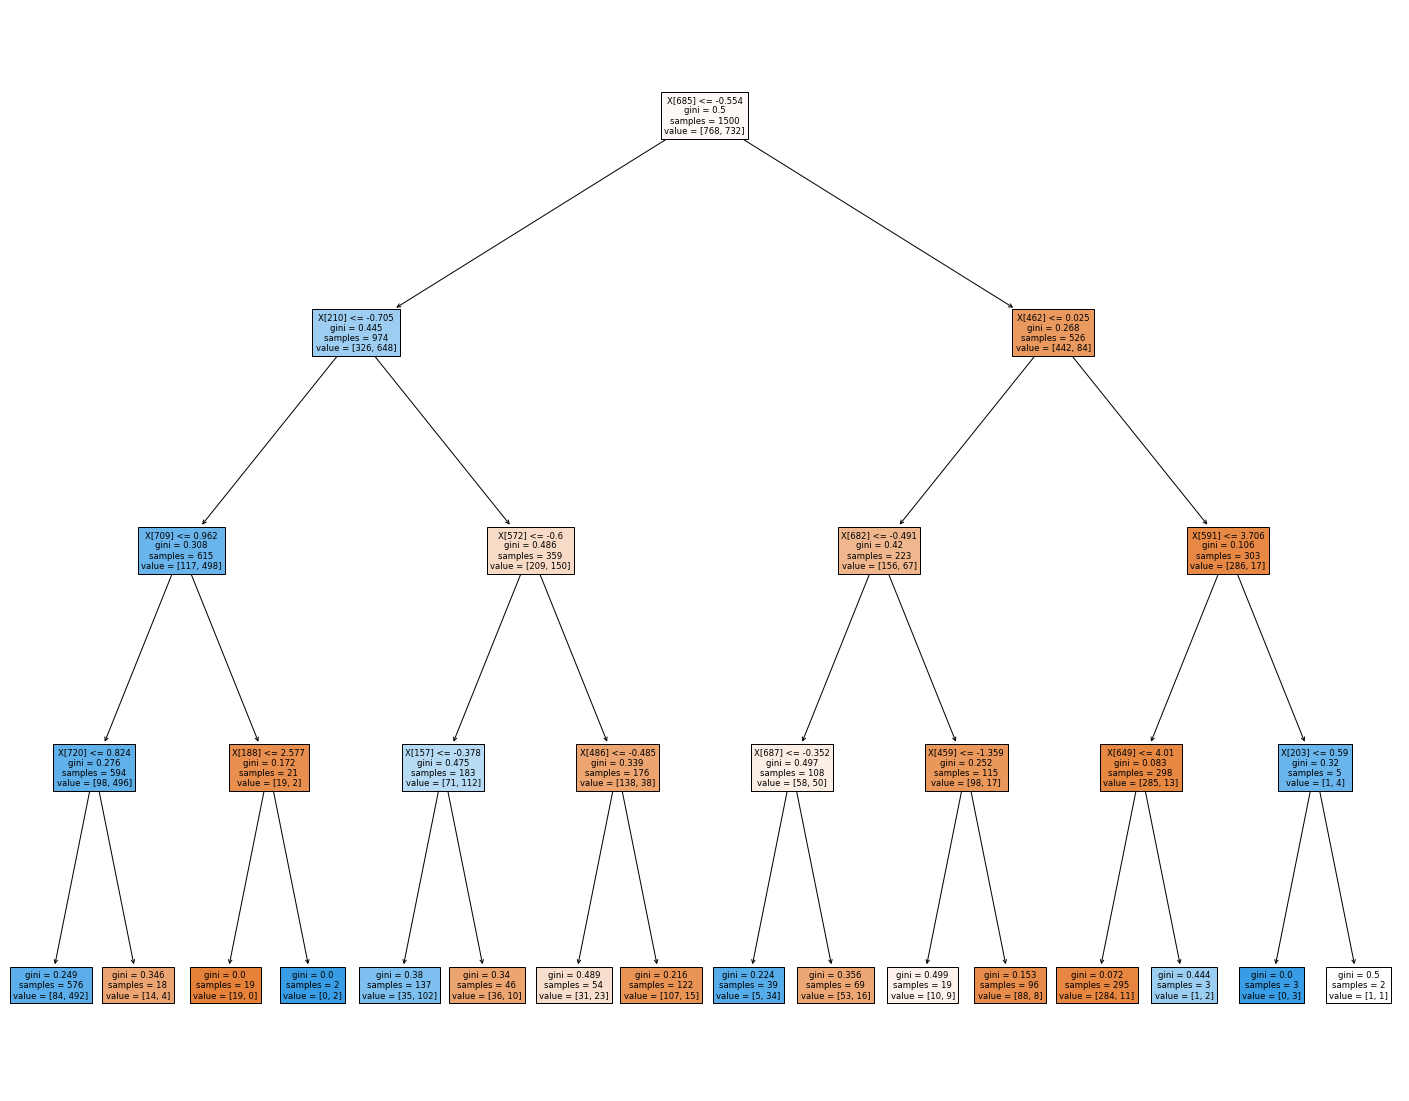

In [ ]:
fig = plt.figure(figsize=(25,20))
plot_tree(dtc_best_param, filled=True)
fig.savefig("decistion_tree.png")

### **With PCA:**
Now we are going to perform decision tree with a little bit of more preprocessing which is using PCA.

After an intensive gridsearch was used with pipelining, we found eventually that taking 32 components is the best for almost all types of classifiers on our particular data.

In [ ]:
n_components = 32

pca = PCA(n_components=n_components)
X_PCA_train = pca.fit_transform(X_train)
X_PCA_test = pca.transform(X_test)
dtc_pca = DecisionTreeClassifier(max_depth=max_depth).fit(X_PCA_train, y_train)
train_score = dtc_pca.score(X_PCA_train, y_train) 
test_score = dtc_pca.score(X_PCA_test, y_test)
print_scores(train_score, test_score, "Decision tree with PCA")

The train score that we got using Decision tree with PCA is: 0.8733333333333333
The test score that we got using Decision tree with PCA is: 0.848


As we can see from above, with PCA, the results improved drastically. 

In fact, PCA doesn't only reduce dimensinality, but it compresses useful data of our 784 features into a reduced amount of features (32). 
This explains the improvement, since the tree now can make a more efficient decision that is built on more than one 'normal' feature at each step. 

## **Random Forest**
Although random forest is also a type of decision tree, we hope that it will give us a better accuracy since it performs a type of bagging on the initial data that we provide for it.

In fact, bagging helps reduce the variance of the results, hence yielding better consistency for the predictions.

### **Without PCA:**
We will start by making decision tree without PCA.

As introduced in the course, the favorable number of features that should be taken into consideration in each tree is the square root of the total number of features.

In our case, it is 28. (784 = 28*28)


In [ ]:
rfr = RandomForestClassifier(min_samples_leaf=2, max_features="sqrt")
rfr.fit(X_train, y_train)
train_score = rfr.score(X_train, y_train)
test_score = rfr.score(X_test, y_test)
print_scores(train_score, test_score, "Random Forest")

The train score that we got using Random Forest is: 0.9993333333333333
The test score that we got using Random Forest is: 0.866


Okay great, so the hypothesis that we stated is true and the accuracy of the random forest is much better than that of the decision tree, but there is still some overfitting since no maximum depth was specified, nor a certain amount of bags (number of created decision trees with random features).

In [ ]:
grid = {'max_depth': np.arange(dtc.get_depth()), 'n_estimators': [40, 48, 52, 56, 60, 64]}
rfc = GridSearchCV(estimator = RandomForestClassifier(), param_grid = grid, n_jobs=-1)
rfc.fit(X_train,y_train)
print(rfc.best_score_)
print(rfc.best_params_)

0.85
{'max_depth': 8, 'n_estimators': 48}


In [ ]:
max_depth = rfc.best_params_['max_depth']
n_estimators = rfc.best_params_['n_estimators']

rfc_best_params = RandomForestClassifier(max_depth=max_depth,
                                         n_estimators=n_estimators,
                                         min_samples_leaf=2,
                                         max_features="sqrt")
rfc_best_params.fit(X_train, y_train)
train_score = rfc_best_params.score(X_train, y_train) 
test_score = rfc_best_params.score(X_test, y_test)
print_scores(train_score, test_score, "Random Forest with best parameters")

The train score that we got using Random Forest with best parameters is: 0.96
The test score that we got using Random Forest with best parameters is: 0.872


Great! Accuracy improved greatly, but this is definitly not enough. Our main goal is to reach somewhere around 0.95 accuracy.

### **With PCA:**
Now we are going to perform decision tree with a little bit of more preprocessing which is using PCA

In [ ]:
rfc_pca = RandomForestClassifier(max_depth = max_depth,
                                 n_estimators = n_estimators,
                                 min_samples_leaf=2,
                                 max_features="sqrt")
rfc_pca.fit(X_PCA_train, y_train)
train_score = rfc_pca.score(X_PCA_train, y_train) 
test_score = rfc_pca.score(X_PCA_test, y_test)
print_scores(train_score, test_score, "Random Forest with PCA")

The train score that we got using Random Forest with PCA is: 0.948
The test score that we got using Random Forest with PCA is: 0.886


As we can see, PCA improved for us the accuracy even more. A bit!!

## **Support Vector Machine**
Now we start with the big guns. In the last couple of classifiers, we had no idea how the data is seperable. Is it linearly seperable? Is it not linearly spereable? This can be known through the usage of the different kernels found in the support vector machine. If the linear kernel has a higher accuracy then the other kernels, then the data is most probably linearly seperable. If not, then it is not linearly seperable. This test is very important since this knowledge will be later useful in building our neural network (to know the number of precpetrons to use).

### **Without PCA:**

##### **Linear SVC:**
We will start by a linear SVM without PCA.

To test the hypothesis of linear separability, we build an SVM over all the data:

In [ ]:
linear_seperability = SVC(kernel="linear")
linear_seperability.fit(X, y)
score = linear_seperability.score(X, y) 
print("The score is {}".format(score))

The score is 0.9915


So as seen from the above classifier, the training accuracy is almost 1 which signifies that the data is almost ***linearly seperable***. We can also conclude that only 17 images are creating this non-linearity. This finding is very important moving forward. Now let us try to find the best parameter for the SVC with linear kernel.

Since the data is almost linearly separable, we know that a small level of data is in the wrong side of the separator, this will lead us not to test very small values of C, since it won't have any improved generality over our predictions.

In [ ]:
linear_svc = SVC(kernel="linear")
linear_svc.fit(X_train, y_train)
train_score = linear_svc.score(X_train, y_train) 
test_score = linear_svc.score(X_test, y_test)
print_scores(train_score, test_score, "linear SVC")

The train score that we got using linear SVC is: 1.0
The test score that we got using linear SVC is: 0.742


In [ ]:
grid = {'C': np.linspace(-2, 2, 13)}
svc_best_param = GridSearchCV(estimator = SVC(kernel="linear"), param_grid = grid, n_jobs=-1)
svc_best_param.fit(X_train,y_train)
print(svc_best_param.best_score_)
print(svc_best_param.best_params_)

0.7593333333333332
{'C': 0.33333333333333304}


In [ ]:
c = svc_best_param.best_params_['C']

linear_svc_best_param = SVC(kernel="linear", C = c)
linear_svc_best_param.fit(X_train, y_train)
train_score = linear_svc_best_param.score(X_train, y_train) 
test_score = linear_svc_best_param.score(X_test, y_test)
print_scores(train_score, test_score, "linear SVC with best parameter")

The train score that we got using linear SVC with best parameter is: 0.9953333333333333
The test score that we got using linear SVC with best parameter is: 0.752


As we can see although the data is seemingly linearly seperable in the case of the training data, the model that we made gives a poor performance when predicting over the test set.

 So we have to look at the other type of kernels to see there performance with the data in hand.

##### **Gaussian Kernel SVC:**

In [ ]:
rbf_svc = SVC(kernel="rbf")
rbf_svc.fit(X_train, y_train)
train_score = rbf_svc.score(X_train, y_train) 
test_score = rbf_svc.score(X_test, y_test)
print_scores(train_score, test_score, "RBF SVC")

The train score that we got using RBF SVC is: 0.9626666666666667
The test score that we got using RBF SVC is: 0.876


In [ ]:
grid = {'C' : np.logspace(-1, 2, 11), 'gamma' : np.logspace(-5, 1, 11)}
rbf_best_param = GridSearchCV(estimator=SVC(kernel = 'rbf'),
                              param_grid=grid,
                              n_jobs=-1)
rbf_best_param.fit(X_train,y_train)
print(rbf_best_param.best_score_)
print(rbf_best_param.best_params_)

0.866
{'C': 26.101572156825373, 'gamma': 0.001}


In [ ]:
c_rbf = rbf_best_param.best_params_['C']
gamma = rbf_best_param.best_params_['gamma']

rbf_best_param_svc = SVC(kernel="rbf", C = c_rbf, gamma=gamma)
rbf_best_param_svc.fit(X_train, y_train)
train_score = rbf_best_param_svc.score(X_train, y_train) 
test_score = rbf_best_param_svc.score(X_test, y_test)
print_scores(train_score, test_score, "RBF SVC with best parameters")

The train score that we got using RBF SVC with best parameters is: 1.0
The test score that we got using RBF SVC with best parameters is: 0.88


As we can see, the accuracy improved greatly due to the fact that now  we have the optimal parameters. Now after trying the rbf kernel, it is time to test the polynomial kernel. We suspect that it won't give us as good results as the rbf, but it still is worth the shot.

##### **Polynomial Kernel SVC:**

In [ ]:
poly_svc = SVC(kernel="poly", degree=3, coef0=0.15, C=10)
poly_svc.fit(X_train, y_train)
train_score = poly_svc.score(X_train, y_train) 
test_score = poly_svc.score(X_test, y_test)
print_scores(train_score, test_score, "Polynomial SVC")

The train score that we got using Polynomial SVC is: 1.0
The test score that we got using Polynomial SVC is: 0.906


In [ ]:
grid = {'C' : np.logspace(0, 3, 13), 'degree' : np.arange(7)}
poly_best_param = GridSearchCV(estimator = SVC(kernel = 'poly',
                                               coef0=0.15,
                                               gamma = gamma),
                                param_grid = grid,
                                n_jobs=-1)
poly_best_param.fit(X_train,y_train)
print(poly_best_param.best_score_)
print(poly_best_param.best_params_)

0.882
{'C': 31.622776601683793, 'degree': 3}


In [ ]:
degree = poly_best_param.best_params_['degree']
c_poly = poly_best_param.best_params_['C']

poly_best_param_svc = SVC(kernel="poly", C=c_poly,
                          degree=degree, gamma=gamma,
                          coef0=0.15)
poly_best_param_svc.fit(X_train, y_train)
train_score = poly_best_param_svc.score(X_train, y_train) 
test_score = poly_best_param_svc.score(X_test, y_test)
print_scores(train_score, test_score, "Polynomial SVC with best parameters")

The train score that we got using Polynomial SVC with best parameters is: 1.0
The test score that we got using Polynomial SVC with best parameters is: 0.906


### **With PCA:**
Now we are going to perform decision tree with a little bit of more preprocessing which is using PCA

In [ ]:
linear_pca_svc = SVC(kernel="linear", C=c)
linear_pca_svc.fit(X_PCA_train, y_train)
train_score = linear_pca_svc.score(X_PCA_train, y_train) 
test_score = linear_pca_svc.score(X_PCA_test, y_test)
print_scores(train_score, test_score, "linear SVC with PCA")

The train score that we got using linear SVC with PCA is: 0.8666666666666667
The test score that we got using linear SVC with PCA is: 0.858


In [ ]:
rbf_pca_svc = SVC(kernel="rbf", C=c_rbf, gamma=gamma*0.8)
rbf_pca_svc.fit(X_PCA_train, y_train)
train_score = rbf_pca_svc.score(X_PCA_train, y_train) 
test_score = rbf_pca_svc.score(X_PCA_test, y_test)
print_scores(train_score, test_score, "RBF SVC with PCA")

The train score that we got using RBF SVC with PCA is: 0.9586666666666667
The test score that we got using RBF SVC with PCA is: 0.9


In [ ]:
poly_PCA_svc = SVC(kernel="poly", C = c_poly,
                   degree = degree, gamma = gamma*0.95,
                   coef0=0.15)
poly_PCA_svc.fit(X_PCA_train, y_train)
train_score = poly_PCA_svc.score(X_PCA_train, y_train) 
test_score = poly_PCA_svc.score(X_PCA_test, y_test)
print_scores(train_score, test_score, "Polynomial SVC with PCA")

The train score that we got using Polynomial SVC with PCA is: 0.9593333333333334
The test score that we got using Polynomial SVC with PCA is: 0.892


We notice a slight improvement of the prediction when we used PCA.

## **Neural Networks**
Now that we have finished from SVM. It is time to go to neural networks with hope that it might give us improved results.

#### **Mullti Layer-Perceptron**

The MLP is based on building multiple layers of perceptrons, where each layer is defined by its dimension, and activation function.

In [ ]:
grid = {'hidden_layer_sizes': np.linspace(690,700,4, dtype=int)}
mlp_best_param = GridSearchCV(estimator=MLPClassifier(solver='lbfgs', alpha=1e-5),
                              param_grid=grid,
                              n_jobs=-1, verbose=3)
mlp_best_param.fit(X_train,y_train)
print(mlp_best_param.best_score_)
print(mlp_best_param.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   49.1s finished


0.8619999999999999
{'hidden_layer_sizes': 686}


In [ ]:
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(686),
                    activation='relu')
# Params:
  # activation{‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default=’relu’
  # solver{‘lbfgs’, ‘sgd’, ‘adam’}, default=’adam’
  # alpha = 0.0001
  # learning_rate{‘constant’, ‘invscaling’, ‘adaptive’}, default=’constant’
mlp.fit(X_train, y_train)
train_score = mlp.score(X_train, y_train) 
test_score = mlp.score(X_test, y_test)
print_scores(train_score, test_score, "Multi Layer Perceptron ")

The train score that we got using Multi Layer Perceptron  is: 1.0
The test score that we got using Multi Layer Perceptron  is: 0.8424242424242424


## Keras implementation:

In [ ]:
input_size = X.shape[1]
output_size = 1  # Binary Classification Problem

nn = Sequential()
nn.add(Dense(300, activation = 'relu', kernel_initializer='normal', input_dim = input_size))
nn.add(Dense(output_size, activation='sigmoid', kernel_initializer='normal'))
nn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

nn_fitted = nn.fit(X_train, y_train, batch_size=5, epochs=10, verbose=1,
                   validation_data=(X_test, y_test))
score = nn.evaluate(X_test, y_test, verbose=0) 
print('Test accuracy:', score[1])

Epoch 1/10
268/268 [==============================] - 1s 4ms/step - loss: 0.4529 - accuracy: 0.8058 - val_loss: 0.3605 - val_accuracy: 0.8439
Epoch 2/10
268/268 [==============================] - 1s 3ms/step - loss: 0.1663 - accuracy: 0.9472 - val_loss: 0.3815 - val_accuracy: 0.8439
Epoch 3/10
268/268 [==============================] - 1s 3ms/step - loss: 0.0861 - accuracy: 0.9753 - val_loss: 0.4014 - val_accuracy: 0.8727
Epoch 4/10
268/268 [==============================] - 1s 3ms/step - loss: 0.0365 - accuracy: 0.9919 - val_loss: 0.4625 - val_accuracy: 0.8455
Epoch 5/10
268/268 [==============================] - 1s 3ms/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 0.4999 - val_accuracy: 0.8576
Epoch 6/10
268/268 [==============================] - 1s 3ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.5236 - val_accuracy: 0.8545
Epoch 7/10
268/268 [==============================] - 1s 3ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.5318 - val_accuracy: 0.8591
Epoch 

After trying out multiple models, we settle on a 3-hidden layer neural network, where the dimension of each layer decreases progressively.

Also, after we tried the 0,1 classifier in the first neural network, where the final output is of dimension 1, we now try the softmax activation function.

This means that our final layer shows two-dimensions (one for grapes, the other for ant), and then classifies them based on the softmax activation function.

According to the course, the usual choice of kenel initializer's variance is the invers sqaure root of the layer dimension.

In [ ]:
def opt_init(dim):
  return initializers.RandomNormal(mean=0.0, stddev=1/np.sqrt(dim))

def nn_model():
  nn = Sequential()

  size1=650
  nn.add(Dense(size1, activation='relu', kernel_initializer=opt_init(size1), 
               input_dim=input_size))
  size2=48
  nn.add(Dense(size2, activation='relu', kernel_initializer=opt_init(size2)))
  size3=12
  nn.add(Dense(size3, activation='sigmoid', kernel_initializer=opt_init(size3),
               bias_initializer=initializers.Zeros()))

  nn.add(Dense(output_onehot, activation='softmax', kernel_initializer='normal'))
  
  opt = optimizers.Adam(lr=0.0001, decay=1e-6)
  nn.compile(optimizer = opt, loss = 'binary_crossentropy', metrics=['accuracy'])
  return nn

In [ ]:
batch_size = 20
epochs = 10
input_size = X_train.shape[1]

y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)
output_onehot = y_test_onehot.shape[1]

nn_onehot = nn_model()
nn_fitted = nn_onehot.fit(X_train, y_train_onehot,
                          batch_size=batch_size, epochs=epochs,
                          verbose=1, validation_data=(X_test, y_test_onehot))
score = nn_onehot.evaluate(X_test, y_test_onehot, verbose=0) 
print('Test accuracy:', score[1])

Epoch 1/10
67/67 [==============================] - 1s 9ms/step - loss: 0.6738 - accuracy: 0.7085 - val_loss: 0.6389 - val_accuracy: 0.8409
Epoch 2/10
67/67 [==============================] - 0s 7ms/step - loss: 0.6306 - accuracy: 0.8682 - val_loss: 0.6205 - val_accuracy: 0.8621
Epoch 3/10
67/67 [==============================] - 0s 7ms/step - loss: 0.6103 - accuracy: 0.8830 - val_loss: 0.6046 - val_accuracy: 0.8667
Epoch 4/10
67/67 [==============================] - 0s 6ms/step - loss: 0.5874 - accuracy: 0.9040 - val_loss: 0.5900 - val_accuracy: 0.8697
Epoch 5/10
67/67 [==============================] - 0s 7ms/step - loss: 0.5697 - accuracy: 0.9167 - val_loss: 0.5771 - val_accuracy: 0.8697
Epoch 6/10
67/67 [==============================] - 0s 7ms/step - loss: 0.5528 - accuracy: 0.9317 - val_loss: 0.5640 - val_accuracy: 0.8727
Epoch 7/10
67/67 [==============================] - 0s 7ms/step - loss: 0.5363 - accuracy: 0.9329 - val_loss: 0.5521 - val_accuracy: 0.8803
Epoch 8/10
67/67 [==

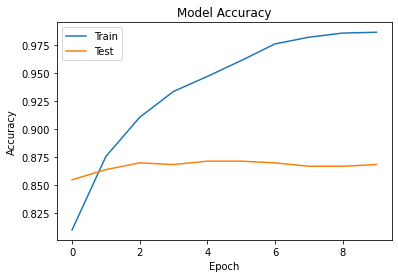

In [ ]:
plt.plot(nn_fitted.history["accuracy"])
plt.plot(nn_fitted.history["val_accuracy"])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0,1])
plt.legend(['Train', 'Test'])
plt.show()

In [ ]:
score, nn_onehot.summary()

Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_226 (Dense)            (None, 650)               510250    
_________________________________________________________________
dense_227 (Dense)            (None, 48)                31248     
_________________________________________________________________
dense_228 (Dense)            (None, 12)                588       
_________________________________________________________________
dense_229 (Dense)            (None, 2)                 26        
Total params: 542,112
Trainable params: 542,112
Non-trainable params: 0
_________________________________________________________________


([0.5205456614494324, 0.8803030252456665], None)

#### **Convolutional Neural Network**

After doing some research, we found out that convolutional neural networks work well with images in general, due to the definition of a convolution. 

Hence, we remodel our data back to images, and build an 8-hidden layer neural network.

In [ ]:
def cnn_model():
    # create model
    model = Sequential()
    
    model.add(Conv2D(30, (5, 5), input_shape=s[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.2))
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    opt = optimizers.Adam(lr=0.0004, decay=1e-6)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [ ]:
# one hot encode outputs
y_train_cnn = to_categorical(y_train)
y_test_cnn = to_categorical(y_test)
num_classes = y_test_cnn.shape[1]

# reshape to be [samples][pixels][width][height]
X_train_cnn = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test_cnn = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
s = X_train_cnn.shape
print(s, num_classes)

(1340, 28, 28, 1) 2


In [ ]:
batch_size = 20
epochs = 20

# build the model
model = cnn_model()
# Fit the model
history = model.fit(X_train_cnn, y_train_cnn,
                    validation_data=(X_test_cnn, y_test_cnn),
                    epochs=epochs, batch_size=batch_size)
# Final evaluation of the model
scores = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print('Final CNN accuracy: ', scores[1]*100, "%")

Epoch 1/20
67/67 [==============================] - 2s 23ms/step - loss: 0.6017 - accuracy: 0.6427 - val_loss: 0.3229 - val_accuracy: 0.8697
Epoch 2/20
67/67 [==============================] - 1s 20ms/step - loss: 0.3452 - accuracy: 0.8621 - val_loss: 0.2935 - val_accuracy: 0.8712
Epoch 3/20
67/67 [==============================] - 1s 20ms/step - loss: 0.2808 - accuracy: 0.8938 - val_loss: 0.2809 - val_accuracy: 0.8803
Epoch 4/20
67/67 [==============================] - 1s 20ms/step - loss: 0.2770 - accuracy: 0.8811 - val_loss: 0.2615 - val_accuracy: 0.9015
Epoch 5/20
67/67 [==============================] - 1s 20ms/step - loss: 0.2309 - accuracy: 0.9173 - val_loss: 0.2355 - val_accuracy: 0.9121
Epoch 6/20
67/67 [==============================] - 1s 21ms/step - loss: 0.2332 - accuracy: 0.9128 - val_loss: 0.2290 - val_accuracy: 0.9091
Epoch 7/20
67/67 [==============================] - 1s 20ms/step - loss: 0.2096 - accuracy: 0.9192 - val_loss: 0.2354 - val_accuracy: 0.9121
Epoch 8/20
67

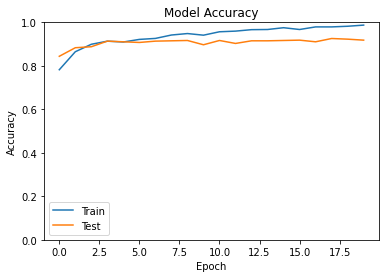

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0,1])
plt.legend(['Train', 'Test'])
plt.show()

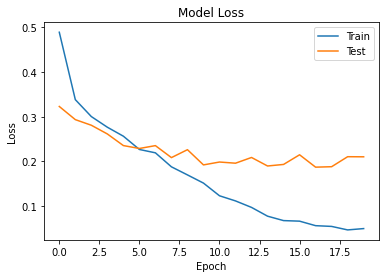

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

We see an improved prediction using a more complex neural network, reaching 94% of test accuracy, with a good learning curve.

However, we should note that ending the neural network with hidden-layers of 'relu' activation function introduces better performance on the data, and protects the model from the vanishing gradients.

Here are some predictions:

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


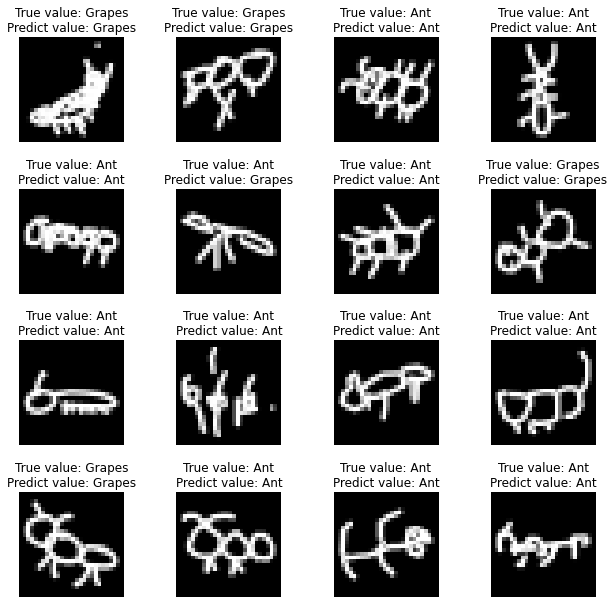

In [ ]:
fig = plt.figure(figsize=(8, 8))
rows = 4
columns = 4
for i in range(1,17):
  nb=np.random.randint(y_test_cnn.shape[0])
  x=X_test_cnn[nb:nb+1]
  true=y_test_cnn[nb][0]
  pred = model.predict_classes(x, verbose=0)
  fig.add_subplot(rows, columns, i)
  plt.imshow(X_raw[nb].reshape(28,28), cmap='gray')
  plt.axis('off')
  tmp = "True value: Grapes\n" if true == 1 else "True value: Ant\n"
  tmp += "Predict value: " + 'Ant' if pred == 1 else 'Predict value: Grapes'
  plt.title(tmp)
  plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=.5, hspace=0.25)